# Leduc et al.

In [1]:
# Load packages
from MScausality.SCM_numpyro import SCM
from MScausality.graph import GraphBuilder

import pandas as pd
import numpy as np
from sklearn import linear_model

import networkx as nx
from y0.graph import NxMixedGraph
from y0.dsl import P, Variable

import pickle

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
%matplotlib inline

## Load network

In [2]:
# pickle_filename = '../data/real_data/sox11_graph_obj_new.pkl'

# with open(pickle_filename, 'rb') as pickle_file:
#     graph = pickle.load(pickle_file)
    
# sub_graph = graph.causal_graph.subgraph([Variable(i) for i in ["BUB1", "STAT3", "CDK1", "TPX2", "CDK2", "FAS", "CDC5L"]])
# Sometimes the pickle wont load bc of y0 using __new__ as a method
def create_subgraph():
    
    graph = NxMixedGraph.from_edges(
        directed=[
            (Variable("BUB1"), Variable("STAT3")), 
            (Variable("STAT3"), Variable("CDK1")),
            (Variable("STAT3"), Variable("TPX2")),
            (Variable("TPX2"), Variable("CDK2")), 
            (Variable("TPX2"), Variable("CDK1")), 
            (Variable("CDK2"), Variable("CDK1")), 
            (Variable("CDK1"), Variable("FAS")), 
            (Variable("CDK1"), Variable("CDC5L")), 
        ],
        undirected=[
            (Variable("CDK1"), Variable("STAT3"))
        ],
    )
    
    return graph


sub_graph = create_subgraph()

NetworkXError: Node BUB1 has no position.

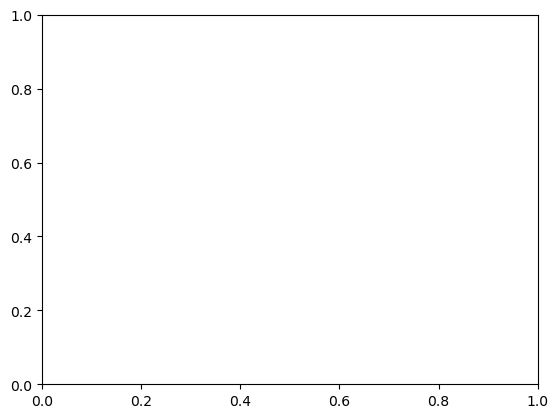

In [3]:
# graph.plot_latent_graph(figure_size=(12, 8))
sub_graph.draw()

## Load experimental data

#### If pickle obj loads

In [4]:
data = graph.experimental_data
data.head()

NameError: name 'graph' is not defined

Filter out any rows that had no measurements in our graph

In [39]:
graph_nodes = [str(i) for i in list(sub_graph.nodes())]
data = data.loc[:, graph_nodes].dropna(how="all")

Filter out any nodes not need for query of interest (speeds up model greatly)

#### Else if pickle cant load

In [5]:
def prep_experimental_data(experimental_data, data_type="TMT", protein_format=None):
    """
    Prepares experimental data for graph building.

    :param data_type: One of 'TMT', 'LFQ'
    :param protein_format: One of None, 'UniProtKB_AC/ID', 'Gene_Namce_Organism'
    :return:
    """
    if data_type == "TMT":
        experimental_data.loc[:, "Run"] = experimental_data.loc[:,"Run"] + "_" + experimental_data.loc[:, "Channel"]

    sexperimental_data = experimental_data.loc[:, ["Protein", "Abundance", "Run"]]

    if protein_format == "UniProtKB_AC/ID":
        experimental_data.loc[:, "Protein"] = experimental_data.loc[:, "Protein"
                                                   ].str.split("|").str[-1].str.split("_").str[0]
    elif protein_format == "Gene_Name_Organism":
        experimental_data.loc[:, "Protein"] = experimental_data.loc[:, "Protein"].str.split("_").str[0]

    experimental_data = experimental_data.groupby(["Protein", "Run"])["Abundance"].sum().reset_index()
    experimental_data = pd.pivot_table(data=experimental_data,
                                            index='Run', columns='Protein',
                                            values='Abundance')
    return experimental_data

In [6]:
experimental_data = pd.read_csv("/mnt/d/OneDrive - Northeastern University/Northeastern/Research/MS_data/Single_cell/Leduc/MSstats/MSstats_summarized.csv")
data = prep_experimental_data(experimental_data, data_type="TMT", protein_format="UniProtKB_AC/ID")

In [7]:
data.head()

Protein,1433B,1433E,1433F,1433G,1433S,1433T,1433Z,2A5D,2AAA,2ABA,...,ZNF66,ZNF8,ZNF84,ZPR1,ZRAB2,ZSC12,ZSCA1,ZSWM8,ZYX,ZZEF1
Run,,,,,,,,,,,,,,,,,,,,,
eAL00219_channel10,10.544586,10.106137,8.281940,9.745655,NaN,10.013734,10.618229,NaN,11.277768,9.418214,...,NaN,NaN,NaN,NaN,11.102987,NaN,NaN,NaN,NaN,NaN
eAL00219_channel11,10.713394,9.990120,8.929308,9.920740,NaN,9.545123,9.961990,NaN,9.561274,NaN,...,NaN,NaN,NaN,NaN,10.395346,NaN,NaN,NaN,NaN,NaN
eAL00219_channel13,11.391083,11.542503,8.880829,10.668361,NaN,10.386840,11.999042,NaN,9.924819,9.735413,...,NaN,NaN,NaN,NaN,10.781443,NaN,NaN,NaN,NaN,NaN
eAL00219_channel14,11.898954,12.045455,8.446838,11.436150,NaN,9.942288,11.786971,NaN,9.942417,NaN,...,NaN,NaN,NaN,NaN,10.759120,NaN,NaN,NaN,NaN,NaN
eAL00219_channel15,11.547041,11.438948,9.416755,10.863875,NaN,10.461396,11.821606,NaN,10.824285,NaN,...,NaN,NaN,NaN,NaN,12.775311,NaN,NaN,NaN,NaN,NaN


## Initial analysis

Text(0, 0.5, 'CDC5L')

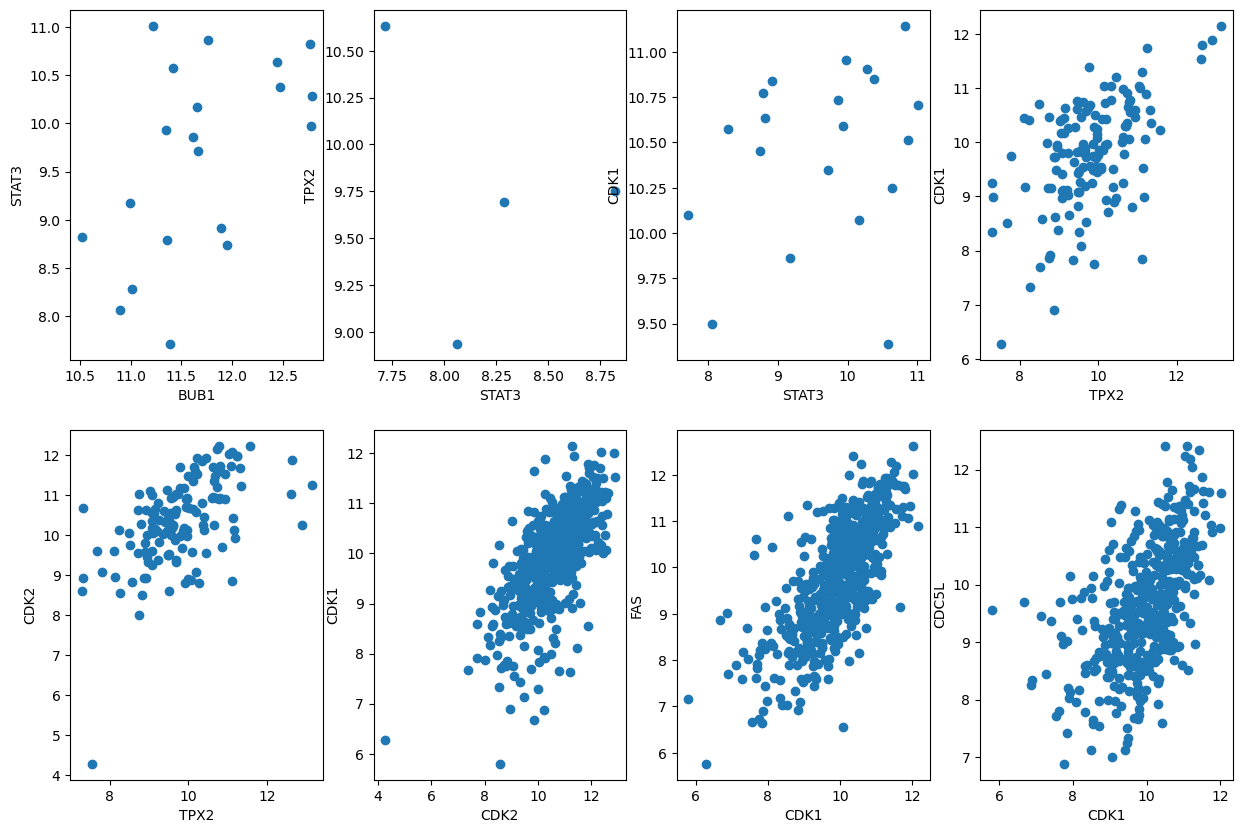

In [8]:
fig, ax = plt.subplots(2,4,figsize=(15,10))
ax[0,0].scatter(data.loc[:, "BUB1"],
             data.loc[:, "STAT3"])
ax[0,1].scatter(data.loc[:, "STAT3"],
             data.loc[:, "TPX2"])
ax[0,2].scatter(data.loc[:, "STAT3"],
             data.loc[:, "CDK1"])
ax[0,3].scatter(data.loc[:, "TPX2"],
             data.loc[:, "CDK1"])
ax[1,0].scatter(data.loc[:, "TPX2"],
             data.loc[:, "CDK2"])
ax[1,1].scatter(data.loc[:, "CDK2"],
             data.loc[:, "CDK1"])
ax[1,2].scatter(data.loc[:, "CDK1"],
             data.loc[:, "FAS"])
ax[1,3].scatter(data.loc[:, "CDK1"],
             data.loc[:, "CDC5L"])

ax[0,0].set_xlabel("BUB1")
ax[0,0].set_ylabel("STAT3")
ax[0,1].set_xlabel("STAT3")
ax[0,1].set_ylabel("TPX2")
ax[0,2].set_xlabel("STAT3")
ax[0,2].set_ylabel("CDK1")
ax[0,3].set_xlabel("TPX2")
ax[0,3].set_ylabel("CDK1")
ax[1,0].set_xlabel("TPX2")
ax[1,0].set_ylabel("CDK2")
ax[1,1].set_xlabel("CDK2")
ax[1,1].set_ylabel("CDK1")
ax[1,2].set_xlabel("CDK1")
ax[1,2].set_ylabel("FAS")
ax[1,3].set_xlabel("CDK1")
ax[1,3].set_ylabel("CDC5L")

Text(0, 0.5, 'FAS')

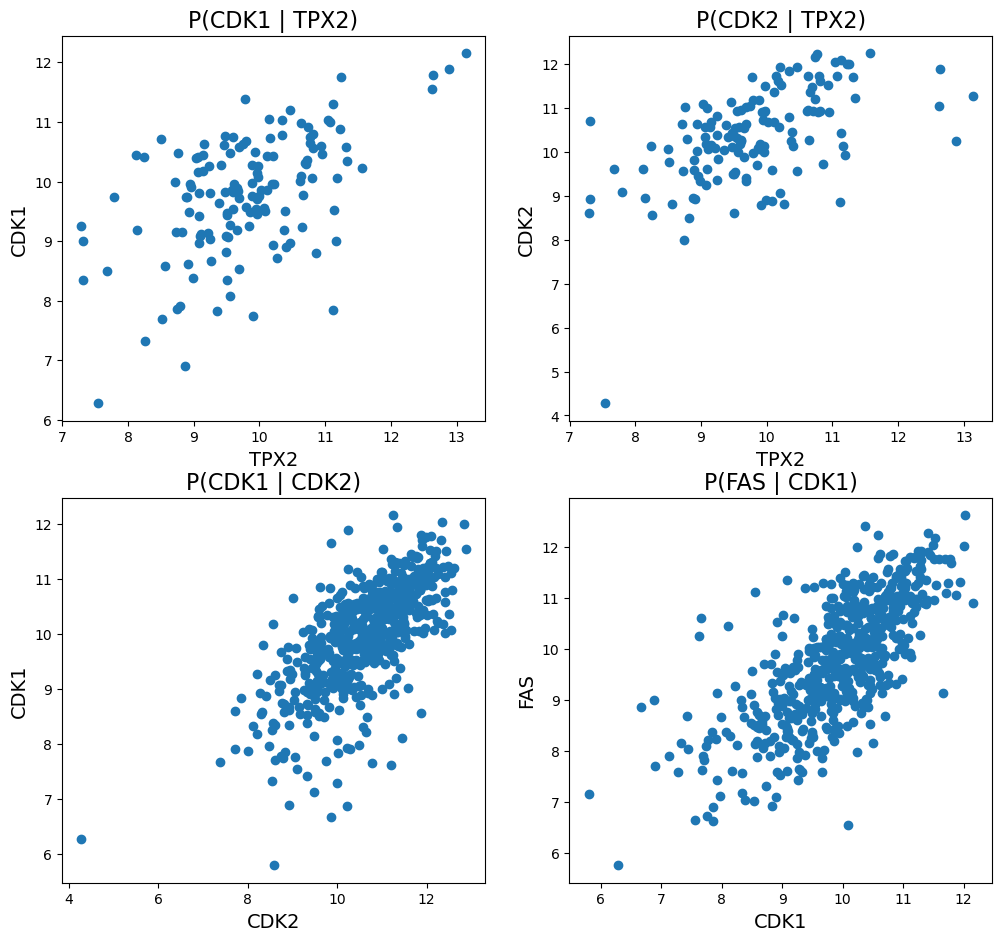

In [19]:
fig, ax = plt.subplots(2,2,figsize=(12,11))
ax[0,0].scatter(data.loc[:, "TPX2"],
             data.loc[:, "CDK1"])
ax[0,1].scatter(data.loc[:, "TPX2"],
             data.loc[:, "CDK2"])
ax[1,0].scatter(data.loc[:, "CDK2"],
             data.loc[:, "CDK1"])
ax[1,1].scatter(data.loc[:, "CDK1"],
             data.loc[:, "FAS"])

ax[0,0].set_title("P(CDK1 | TPX2)", size=16)
ax[0,1].set_title("P(CDK2 | TPX2)", size=16)
ax[1,0].set_title("P(CDK1 | CDK2)", size=16)
ax[1,1].set_title("P(FAS | CDK1)", size=16)

ax[0,0].set_xlabel("TPX2", size=14)
ax[0,0].set_ylabel("CDK1", size=14)
ax[0,1].set_xlabel("TPX2", size=14)
ax[0,1].set_ylabel("CDK2", size=14)
ax[1,0].set_xlabel("CDK2", size=14)
ax[1,0].set_ylabel("CDK1", size=14)
ax[1,1].set_xlabel("CDK1", size=14)
ax[1,1].set_ylabel("FAS", size=14)

### Fit model

In [20]:
scm = SCM(data.loc[:, [str(i) for i in sub_graph.nodes()]].dropna(how="all"), sub_graph)
scm.prepare_scm_input()

Finding root nodes...
Adding latent confounders to graph...


In [21]:
scm.fit_scm(num_samples=2000, warmup_steps=8000, num_chains=4)

Determining missing obs...
Running MCMC...


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [162]:
scm.summary_stats

{'BUB1_mean': OrderedDict([('mean', 10.94129),
              ('std', 0.047042493),
              ('median', 10.941277),
              ('5.0%', 10.8609915),
              ('95.0%', 11.01467),
              ('n_eff', 4110.418665472524),
              ('r_hat', 0.9997755146206412)]),
 'BUB1_scale': OrderedDict([('mean', 1.1255718),
              ('std', 0.034151506),
              ('median', 1.1248344),
              ('5.0%', 1.0686748),
              ('95.0%', 1.1805574),
              ('n_eff', 3922.875212230623),
              ('r_hat', 1.001180279150847)]),
 'CDC5L_CDK1_coef': OrderedDict([('mean', 0.593653),
              ('std', 0.045646142),
              ('median', 0.59351826),
              ('5.0%', 0.51525146),
              ('95.0%', 0.664438),
              ('n_eff', 1393.6222488725998),
              ('r_hat', 1.0064496836378023)]),
 'CDC5L_intercept': OrderedDict([('mean', 3.746643),
              ('std', 0.4559972),
              ('median', 3.749674),
              ('5.0%',

In [11]:
scm.intervention("CDK2", "FAS", 10., n=2500)
first_int = scm.intervention_samples

scm.intervention("CDK2", "FAS", 20., n=2500)
second_int = scm.intervention_samples

In [12]:
np.mean(np.array(first_int))

8.886258

In [13]:
np.mean(np.array(second_int))

13.444703

(array([  0.,  50., 100., 150., 200., 250., 300., 350.]),
 [Text(0, 0.0, '0'),
  Text(0, 50.0, '50'),
  Text(0, 100.0, '100'),
  Text(0, 150.0, '150'),
  Text(0, 200.0, '200'),
  Text(0, 250.0, '250'),
  Text(0, 300.0, '300'),
  Text(0, 350.0, '350')])

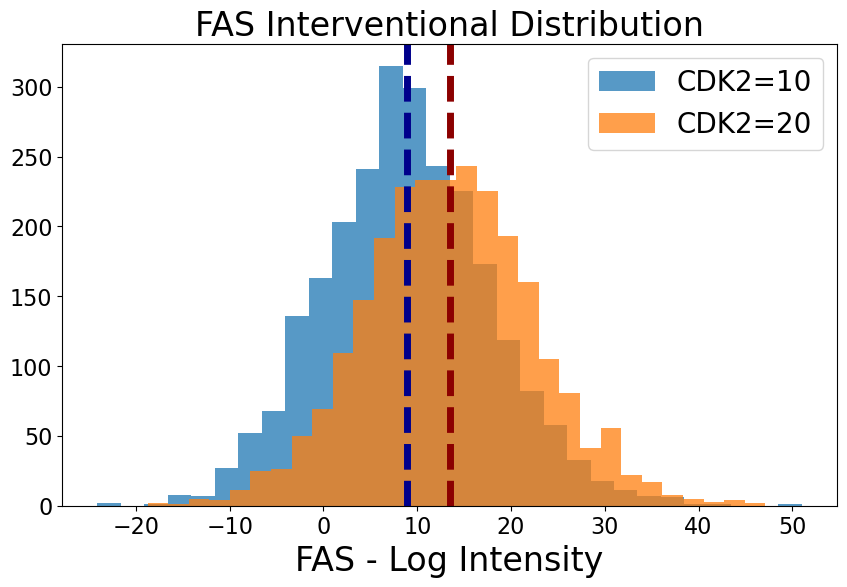

In [28]:
fig, ax = plt.subplots(figsize=(10,6))

ax.hist(np.array(first_int), bins=30, alpha=.75, label="CDK2=10")
ax.axvline(np.mean(np.array(first_int)), color="darkblue", lw = 5, linestyle="dashed")
ax.hist(np.array(second_int), bins=30, alpha=.75, label="CDK2=20")
ax.axvline(np.mean(np.array(second_int)), color="darkred", lw = 5, linestyle="dashed")

ax.legend(fontsize=20)
ax.set_title("FAS Interventional Distribution", size=24)
ax.set_xlabel("FAS - Log Intensity", size=24)
# ax.set_ylabel("Erk", size=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

In [47]:
nodes = [str(i) for i in sub_graph.nodes()]

for i in nodes:
    imp = scm.summary_stats["imp_{0}".format(i)]["mean"]

    ## Add in missing data
    data.loc[:, "imp_{0}".format(i)] = data.loc[:, i].isna()
    data.loc[:, "full_{0}".format(i)] = data.loc[:, i]

    data.loc[data["imp_{0}".format(i)], "full_{0}".format(i)] = imp


In [ ]:
fig, ax = plt.subplots(2,4,figsize=(15,10))
ax[0,0].scatter(data.loc[:, "BUB1"],
             data.loc[:, "STAT3"])
ax[0,1].scatter(data.loc[:, "STAT3"],
             data.loc[:, "TPX2"])
ax[0,2].scatter(data.loc[:, "STAT3"],
             data.loc[:, "CDK1"])
ax[0,3].scatter(data.loc[:, "TPX2"],
             data.loc[:, "CDK1"])
ax[1,0].scatter(data.loc[:, "TPX2"],
             data.loc[:, "CDK2"])
ax[1,1].scatter(data.loc[:, "CDK2"],
             data.loc[:, "CDK1"])
ax[1,2].scatter(data.loc[:, "CDK1"],
             data.loc[:, "FAS"])
ax[1,3].scatter(data.loc[:, "CDK1"],
             data.loc[:, "CDC5L"])

ax[0,0].set_xlabel("BUB1")
ax[0,0].set_ylabel("STAT3")
ax[0,1].set_xlabel("STAT3")
ax[0,1].set_ylabel("TPX2")
ax[0,2].set_xlabel("STAT3")
ax[0,2].set_ylabel("CDK1")
ax[0,3].set_xlabel("TPX2")
ax[0,3].set_ylabel("CDK1")
ax[1,0].set_xlabel("TPX2")
ax[1,0].set_ylabel("CDK2")
ax[1,1].set_xlabel("CDK2")
ax[1,1].set_ylabel("CDK1")
ax[1,2].set_xlabel("CDK1")
ax[1,2].set_ylabel("FAS")
ax[1,3].set_xlabel("CDK1")
ax[1,3].set_ylabel("CDC5L")

In [48]:
edges = sub_graph.directed.edges()

In [49]:
edges

OutEdgeView([(STAT3, CDK1), (STAT3, TPX2), (CDK1, FAS), (CDK1, CDC5L), (CDK2, CDK1), (TPX2, CDK2), (TPX2, CDK1), (BUB1, STAT3)])

In [71]:
present_edges = [("STAT3", "TPX2"), ("STAT3", "CDK1"), ("CDK2", "CDK1")]

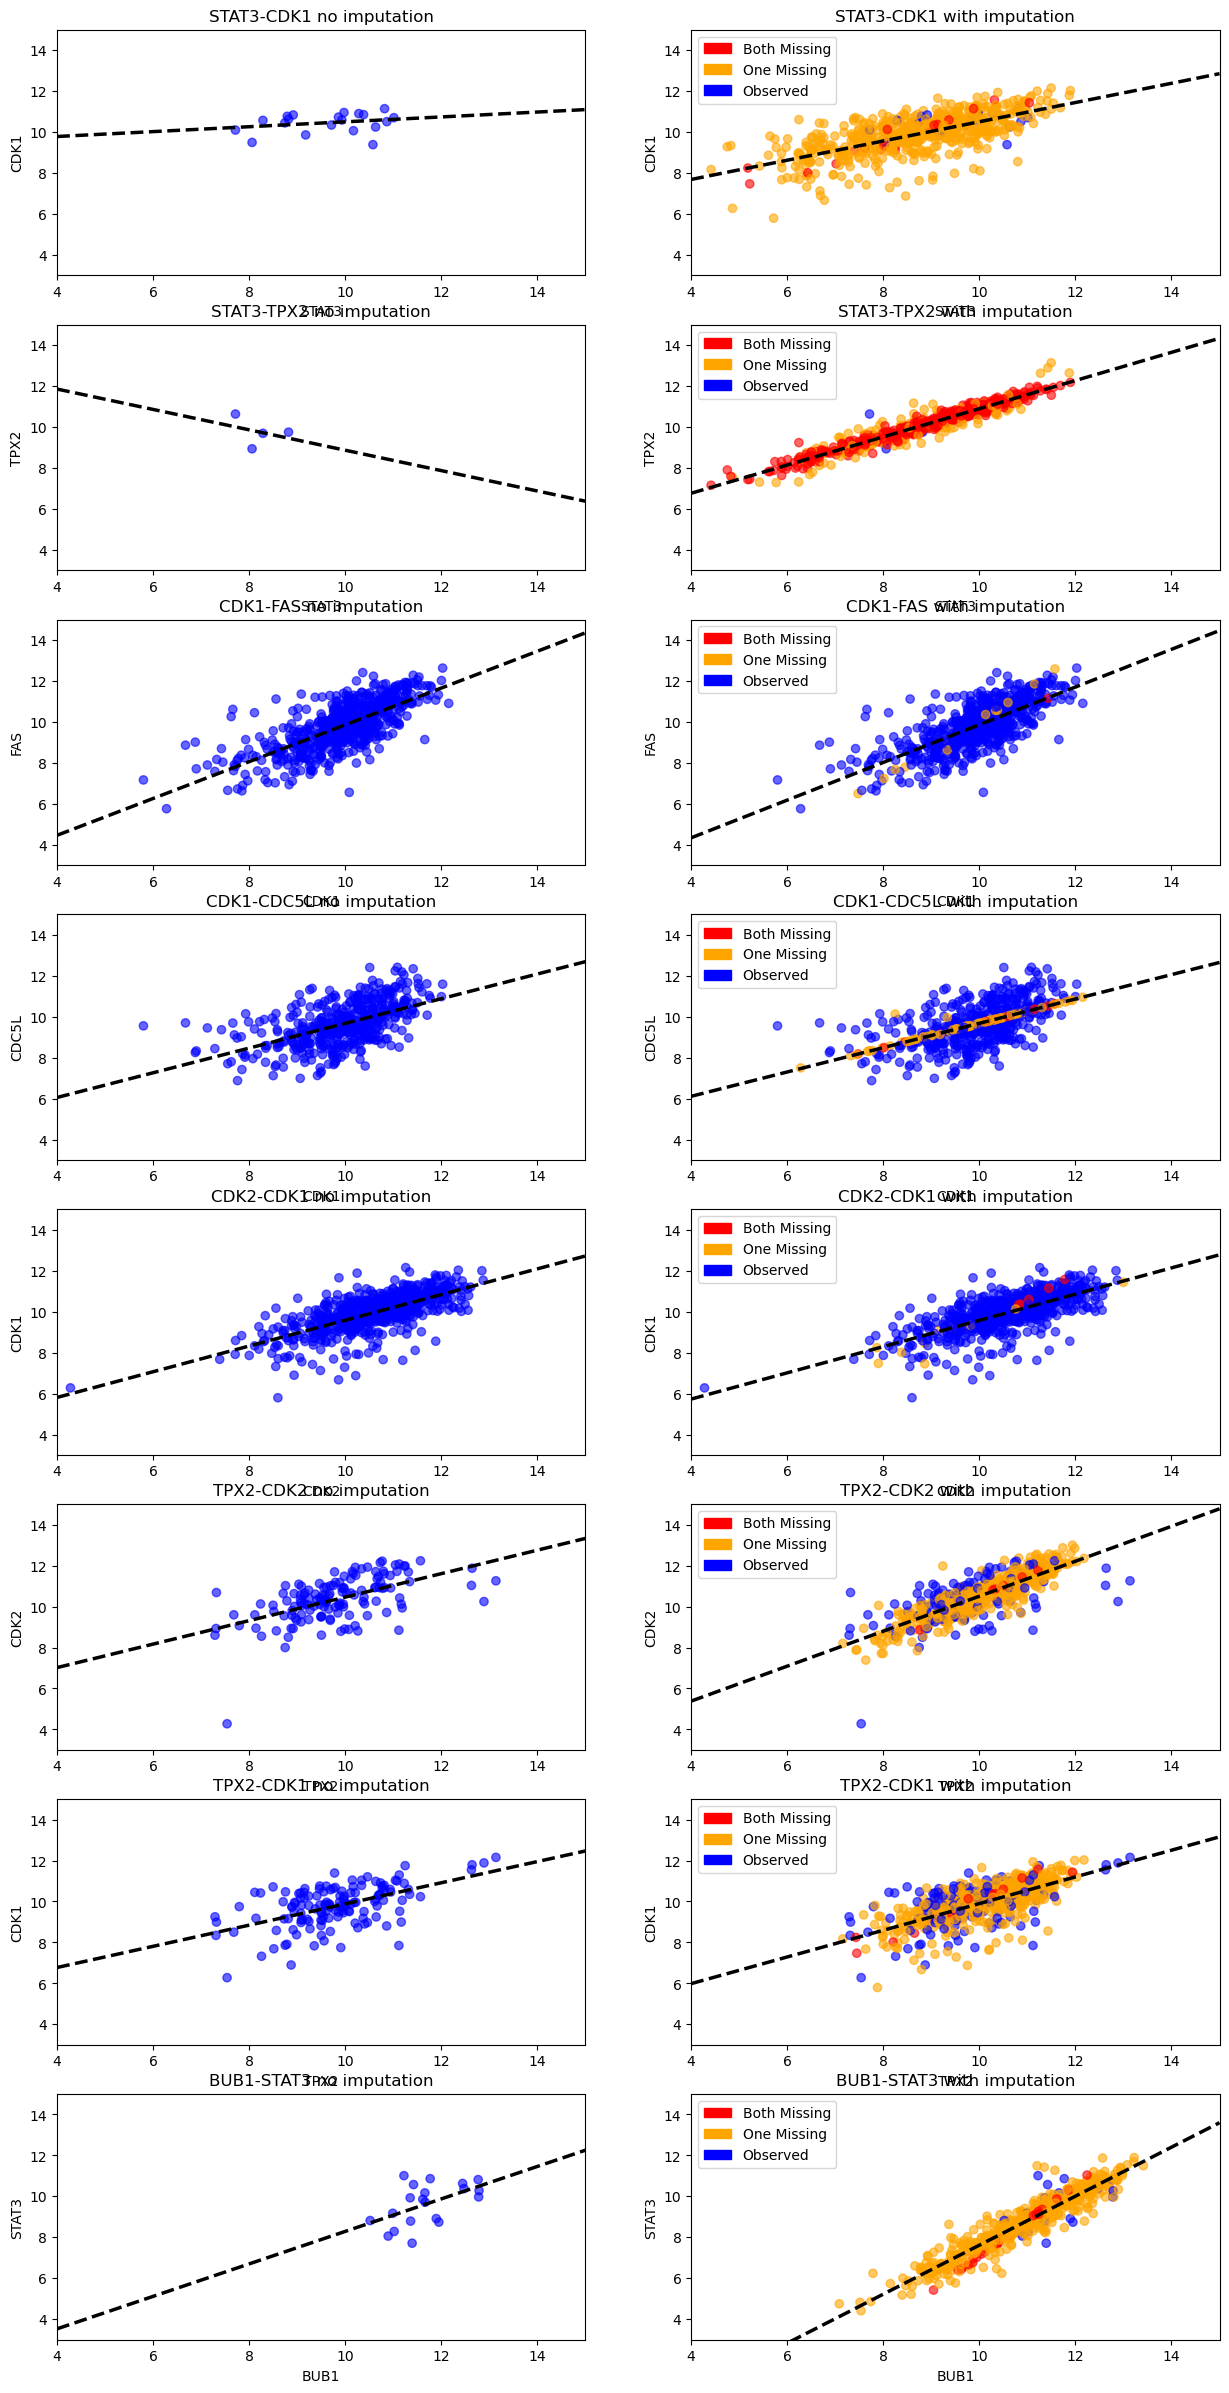

In [70]:
## Plot
plot = 0
fig, ax = plt.subplots(len(edges), 2, figsize=(15,30))
for i in edges:
    
    x_var = str(i[0])
    y_var = str(i[1])
    
    
    lm = linear_model.LinearRegression()
    temp_data = data.loc[:, [x_var, y_var]].dropna()
    x = temp_data[[x_var]]
    y = temp_data[[y_var]]
    lm.fit(x, y)

    imp_lm = linear_model.LinearRegression()
    x = data[["full_{0}".format(x_var)]]
    y = data[["full_{0}".format(y_var)]]
    imp_lm.fit(x, y)

    
    colors = np.where((data["imp_{}".format(x_var)] == True) & \
                       (data["imp_{}".format(y_var)] == True), "Red", 
                      np.where((data["imp_{}".format(x_var)] == True) | \
                               (data["imp_{}".format(y_var)] == True), "Orange", "Blue"))

    ax[plot, 0].scatter(data[x_var], data[y_var], 
                  c=colors, alpha=.6)
    ax[plot, 0].plot(np.arange(4,16), 
               lm.coef_[0]*np.arange(4,16) + lm.intercept_[0], 
               color="black", lw=2.5, linestyle="dashed")

    ax[plot, 1].scatter(data["full_{}".format(x_var)], data["full_{}".format(y_var)], 
                  c=colors, alpha=.6)
    ax[plot, 1].plot(np.arange(4,16), 
               imp_lm.coef_[0]*np.arange(4,16) + imp_lm.intercept_[0], 
               color="black", lw=2.5, linestyle="dashed")

    red_patch = mpatches.Patch(color='red', label='Both Missing')
    orange_patch = mpatches.Patch(color='orange', label='One Missing')
    blue_patch = mpatches.Patch(color='blue', label='Observed')

    ax[plot, 1].legend(handles=[red_patch, orange_patch, blue_patch])
    
    ax[plot, 1].set_xlabel(x_var, size=10)
    ax[plot, 0].set_xlabel(x_var, size=10)

    ax[plot, 0].set_ylabel(y_var, size=10)
    ax[plot, 1].set_ylabel(y_var, size=10)
    
    ax[plot, 0].set_xlim(4,15)
    ax[plot, 1].set_xlim(4,15)
    
    ax[plot, 0].set_ylim(3,15)
    ax[plot, 1].set_ylim(3,15)

    ax[plot, 0].set_title("{0}-{1} no imputation".format(x_var, y_var))
    ax[plot, 1].set_title("{0}-{1} with imputation".format(x_var, y_var))
    
    plot+=1

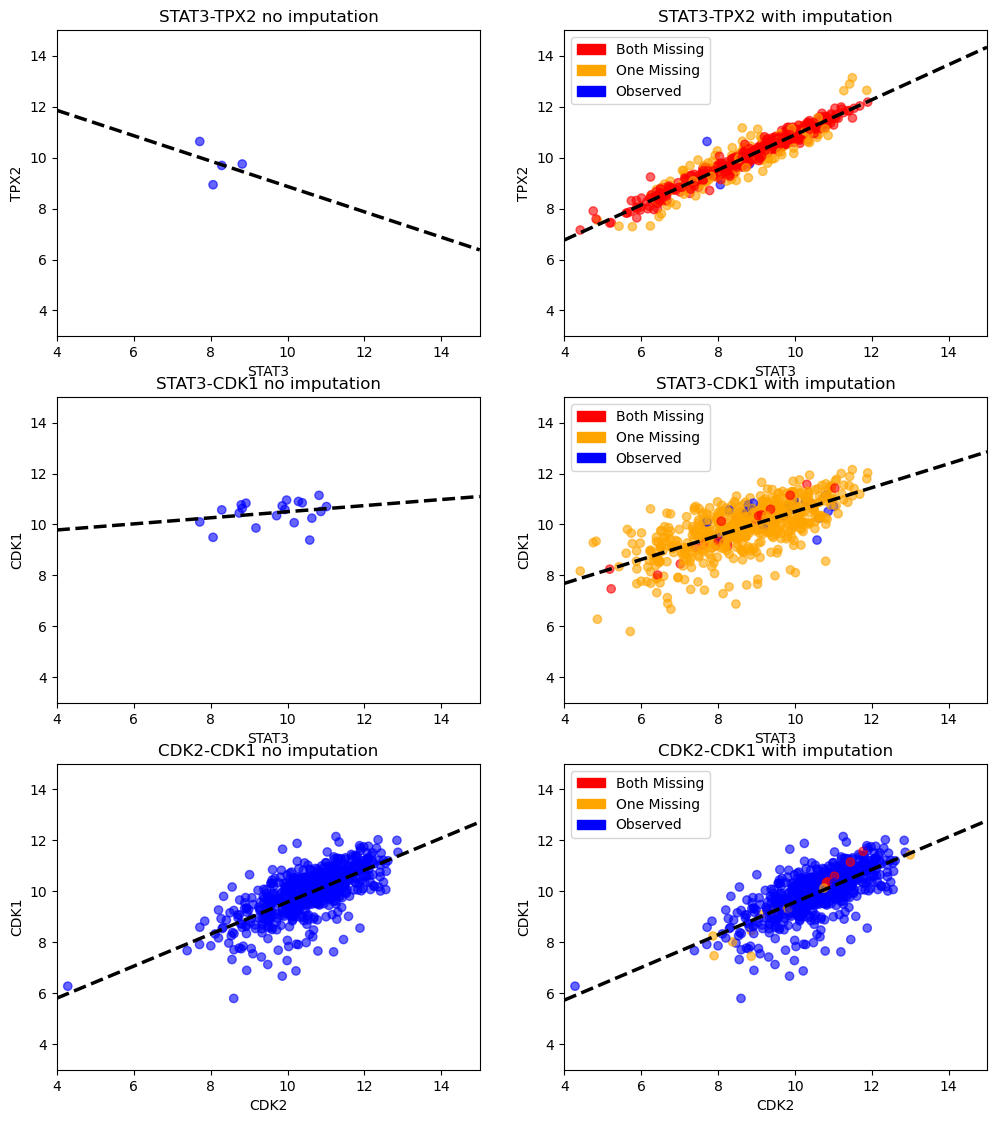

In [75]:
## Plot
plot = 0
fig, ax = plt.subplots(len(present_edges), 2, figsize=(12,13.5))
for i in present_edges:
    
    x_var = str(i[0])
    y_var = str(i[1])
    
    
    lm = linear_model.LinearRegression()
    temp_data = data.loc[:, [x_var, y_var]].dropna()
    x = temp_data[[x_var]]
    y = temp_data[[y_var]]
    lm.fit(x, y)

    imp_lm = linear_model.LinearRegression()
    x = data[["full_{0}".format(x_var)]]
    y = data[["full_{0}".format(y_var)]]
    imp_lm.fit(x, y)

    
    colors = np.where((data["imp_{}".format(x_var)] == True) & \
                       (data["imp_{}".format(y_var)] == True), "Red", 
                      np.where((data["imp_{}".format(x_var)] == True) | \
                               (data["imp_{}".format(y_var)] == True), "Orange", "Blue"))

    ax[plot, 0].scatter(data[x_var], data[y_var], 
                  c=colors, alpha=.6)
    ax[plot, 0].plot(np.arange(4,16), 
               lm.coef_[0]*np.arange(4,16) + lm.intercept_[0], 
               color="black", lw=2.5, linestyle="dashed")

    ax[plot, 1].scatter(data["full_{}".format(x_var)], data["full_{}".format(y_var)], 
                  c=colors, alpha=.6)
    ax[plot, 1].plot(np.arange(4,16), 
               imp_lm.coef_[0]*np.arange(4,16) + imp_lm.intercept_[0], 
               color="black", lw=2.5, linestyle="dashed")

    red_patch = mpatches.Patch(color='red', label='Both Missing')
    orange_patch = mpatches.Patch(color='orange', label='One Missing')
    blue_patch = mpatches.Patch(color='blue', label='Observed')

    ax[plot, 1].legend(handles=[red_patch, orange_patch, blue_patch])
    
    ax[plot, 1].set_xlabel(x_var, size=10)
    ax[plot, 0].set_xlabel(x_var, size=10)

    ax[plot, 0].set_ylabel(y_var, size=10)
    ax[plot, 1].set_ylabel(y_var, size=10)
    
    ax[plot, 0].set_xlim(4,15)
    ax[plot, 1].set_xlim(4,15)
    
    ax[plot, 0].set_ylim(3,15)
    ax[plot, 1].set_ylim(3,15)

    ax[plot, 0].set_title("{0}-{1} no imputation".format(x_var, y_var))
    ax[plot, 1].set_title("{0}-{1} with imputation".format(x_var, y_var))
    
    plot+=1

## Melanoma only

In [23]:
experimental_data = pd.read_csv("/mnt/d/OneDrive - Northeastern University/Northeastern/Research/MS_data/Single_cell/Leduc/MSstats/MSstats_summarized.csv")
mel_data = experimental_data.loc[experimental_data["Condition"] == "m"]

In [24]:
data = prep_experimental_data(mel_data, protein_format="UniProtKB_AC/ID")

In [25]:
graph_nodes = [str(i) for i in sub_graph.nodes()]
data = data.loc[:, graph_nodes].dropna(how="all")

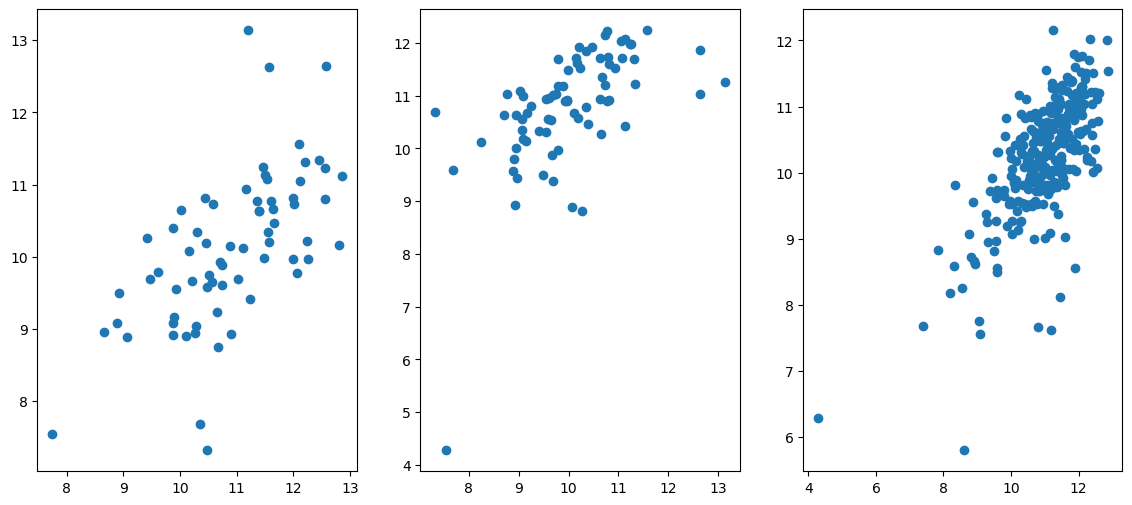

In [26]:
fig, ax = plt.subplots(1,3,figsize=(14,6))
ax[0].scatter(data.loc[:, "BUB1"],
             data.loc[:, "TPX2"])
ax[1].scatter(data.loc[:, "TPX2"],
             data.loc[:, "CDK2"])
ax[2].scatter(data.loc[:, "CDK2"],
             data.loc[:, "CDK1"])

### Fit model

In [27]:
scm = SCM(data, sub_graph)
scm.prepare_scm_input()

Finding root nodes...
Adding latent confounders to graph...


In [28]:
scm.fit_scm(num_samples=2000, warmup_steps=8000, num_chains=4)

Determining missing obs...
Running MCMC...


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

In [29]:
scm.summary_stats

{'BUB1_mean': OrderedDict([('mean', 11.148928),
              ('std', 0.065245114),
              ('median', 11.148396),
              ('5.0%', 11.044583),
              ('95.0%', 11.258745),
              ('n_eff', 2439.1290067789387),
              ('r_hat', 1.000735499058597)]),
 'BUB1_scale': OrderedDict([('mean', 1.0807838),
              ('std', 0.045259207),
              ('median', 1.079252),
              ('5.0%', 1.006186),
              ('95.0%', 1.1525694),
              ('n_eff', 2621.1442013593164),
              ('r_hat', 1.0009302946536083)]),
 'CDC5L_CDK1_coef': OrderedDict([('mean', 0.6836377),
              ('std', 0.065776184),
              ('median', 0.68329716),
              ('5.0%', 0.5762857),
              ('95.0%', 0.7908913),
              ('n_eff', 1295.8731265581173),
              ('r_hat', 1.0031959950270137)]),
 'CDC5L_intercept': OrderedDict([('mean', 2.8349903),
              ('std', 0.6784472),
              ('median', 2.8368196),
              ('5.

In [30]:
scm.intervention("CDK2", "FAS", 10., return_all = False)
first_int = scm.intervention_samples

scm.intervention("CDK2", "FAS", 20.)
second_int = scm.intervention_samples

In [31]:
np.mean(np.array(first_int))

10.420862

In [32]:
np.mean(np.array(second_int))

14.221121

(array([  0.,  20.,  40.,  60.,  80., 100., 120., 140., 160.]),
 [Text(0, 0.0, '0'),
  Text(0, 20.0, '20'),
  Text(0, 40.0, '40'),
  Text(0, 60.0, '60'),
  Text(0, 80.0, '80'),
  Text(0, 100.0, '100'),
  Text(0, 120.0, '120'),
  Text(0, 140.0, '140'),
  Text(0, 160.0, '160')])

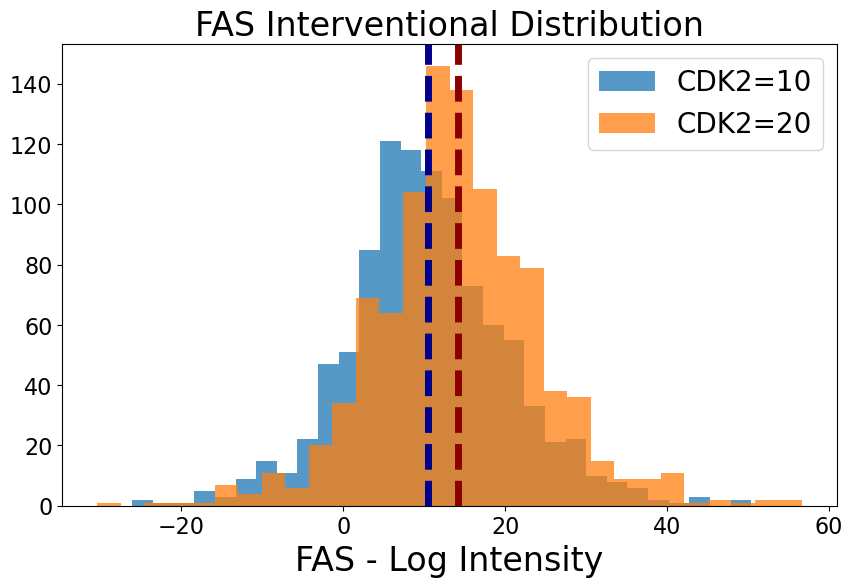

In [35]:
fig, ax = plt.subplots(figsize=(10,6))

ax.hist(np.array(first_int), bins=30, alpha=.75, label="CDK2=10")
ax.axvline(np.mean(np.array(first_int)), color="darkblue", lw = 5, linestyle="dashed")
ax.hist(np.array(second_int), bins=30, alpha=.75, label="CDK2=20")
ax.axvline(np.mean(np.array(second_int)), color="darkred", lw = 5, linestyle="dashed")

ax.legend(fontsize=20)
ax.set_title("FAS Interventional Distribution", size=24)
ax.set_xlabel("FAS - Log Intensity", size=24)
# ax.set_ylabel("Erk", size=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

## Monocyte only

In [97]:
mon_data = experimental_data.loc[experimental_data["Condition"] == "u"]

In [98]:
data = prep_experimental_data(mon_data, protein_format="UniProtKB_AC/ID")

In [99]:
graph_nodes = [str(i) for i in sub_graph.nodes()]
data = data.loc[:, graph_nodes].dropna(how="all")

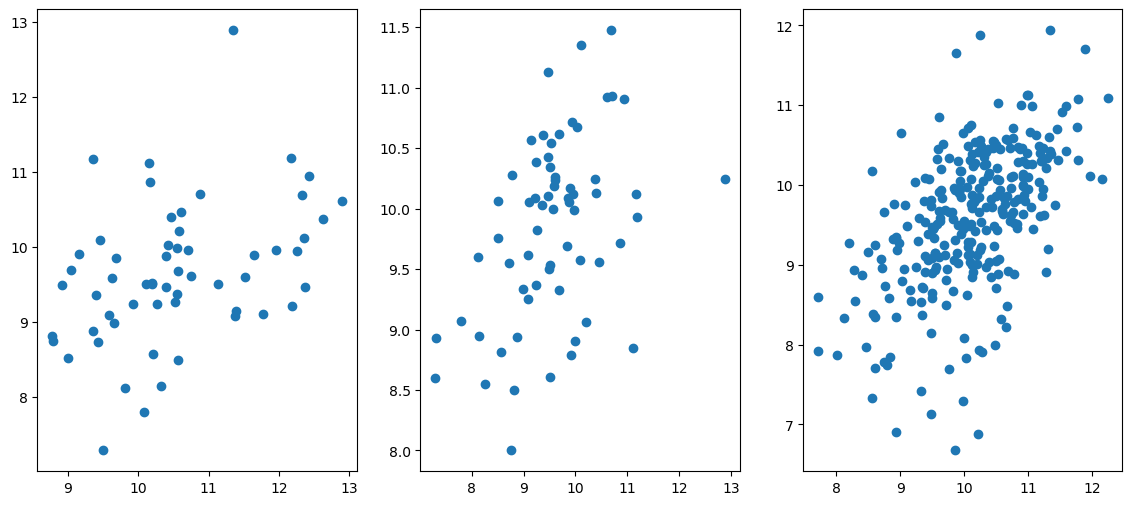

In [66]:
fig, ax = plt.subplots(1,3,figsize=(14,6))
ax[0].scatter(data.loc[:, "BUB1"],
             data.loc[:, "TPX2"])
ax[1].scatter(data.loc[:, "TPX2"],
             data.loc[:, "CDK2"])
ax[2].scatter(data.loc[:, "CDK2"],
             data.loc[:, "CDK1"])

### Fit model

In [174]:
scm = SCM(data, sub_graph)
scm.prepare_scm_input()

Finding root nodes...
Adding latent confounders to graph...


In [175]:
scm.fit_scm(num_samples=1000, warmup_steps=4000, num_chains=4)

Determining missing obs...
Running MCMC...


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

In [48]:
scm.summary_stats

{'BUB1_mean': OrderedDict([('mean', 10.730835),
              ('std', 0.06788874),
              ('median', 10.73127),
              ('5.0%', 10.609964),
              ('95.0%', 10.8318405),
              ('n_eff', 1787.2808628377995),
              ('r_hat', 1.0040539101018378)]),
 'BUB1_scale': OrderedDict([('mean', 1.1434172),
              ('std', 0.050621502),
              ('median', 1.141992),
              ('5.0%', 1.0606978),
              ('95.0%', 1.2244214),
              ('n_eff', 1569.7420577649004),
              ('r_hat', 1.001488514181683)]),
 'CDK1_BUB1_coef': OrderedDict([('mean', 0.09832222),
              ('std', 0.4519988),
              ('median', 0.121651076),
              ('5.0%', -0.670398),
              ('95.0%', 0.8086002),
              ('n_eff', 116.4142064764798),
              ('r_hat', 1.0349652570101864)]),
 'CDK1_CDK2_coef': OrderedDict([('mean', 0.39485845),
              ('std', 0.093347505),
              ('median', 0.39427146),
              ('5

In [176]:
scm.intervention("CDK2", "FAS", 5., return_all = False)
first_int = scm.intervention_samples

scm.intervention("CDK2", "FAS", 20.)
second_int = scm.intervention_samples

In [177]:
np.mean(np.array(first_int))

7.465666

In [178]:
np.mean(np.array(second_int))

13.877089

(array([  0.,  20.,  40.,  60.,  80., 100., 120., 140., 160., 180.]),
 [Text(0, 0.0, '0'),
  Text(0, 20.0, '20'),
  Text(0, 40.0, '40'),
  Text(0, 60.0, '60'),
  Text(0, 80.0, '80'),
  Text(0, 100.0, '100'),
  Text(0, 120.0, '120'),
  Text(0, 140.0, '140'),
  Text(0, 160.0, '160'),
  Text(0, 180.0, '180')])

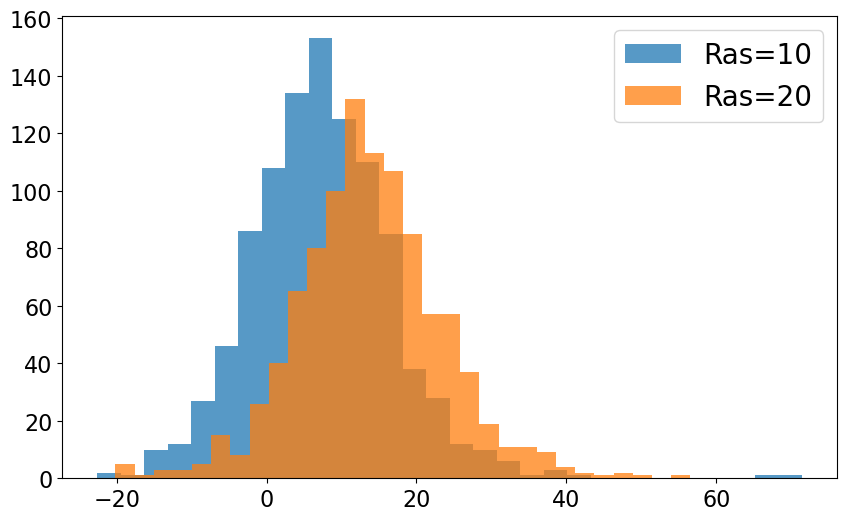

In [180]:
fig, ax = plt.subplots(figsize=(10,6))

ax.hist(np.array(first_int), bins=30, alpha=.75, label="Ras=10")
ax.hist(np.array(second_int), bins=30, alpha=.75, label="Ras=20")

ax.legend(fontsize=20)
# ax.set_title("Erk Interventional Distribution", size=24)
# ax.set_xlabel("Erk - Log Intensity", size=24)
# ax.set_ylabel("Erk", size=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)